# Severity Classification Models for Traffic Accidents
In this notebook, classification models for the severity of traffic crashes will be developed.

In [1]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Capstone/'

%cd $abspath_curr

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Capstone


In [2]:
# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, MultiPolygon
from shapely.wkt import loads
from toolbox import *

## Read Dataset
The dataset is obtained from Chicago Data Potal.

In [4]:
# Read the data
df_train = pd.read_csv("Data/train.csv", index_col=False)
df_val = pd.read_csv("Data/val.csv", index_col=False)
df_test = pd.read_csv("Data/test.csv", index_col=False)

### Model Development - FNN

Encoding the categorical features

In [5]:
df_train = df_train.sample(frac=1, random_state=6501).reset_index(drop=True)

In [6]:
df_train_x = df_train.drop(columns=["Severity"])
y_train = df_train["Severity"].values - 1

df_val_x = df_val.drop(columns=["Severity"])
y_val = df_val["Severity"].values - 1

df_test_x = df_test.drop(columns=["Severity"])
y_test = df_test["Severity"].values - 1

In [7]:
# Concat feature matrics
df_X = pd.concat([df_train_x, df_val_x, df_test_x], sort=False)

#### Encoding cyclic categorical features
* "CRASH_DATE_month", "CRASH_DATE_hour", and "CRASH_DAY_OF_WEEK" are categorical, but also are cyclical.
* Encoding these feature by One-Hot encoding (OHE) will lead to the increase of the demension, which is not prefereable. In addition, the OHE cannot capture the cyclic characteristic in these features. Therefore, encoding utilized trigonometric functions will be applied.

In [8]:
df_X = cyclic_encoding(df_X, ["CRASH_DATE_month", "CRASH_DATE_hour", "CRASH_DAY_OF_WEEK"])

#### Encoding other catogorical features
* Encoding other categorical features than cyclic ones by OHE

In [9]:
df_X = df_X.astype({"POSTED_SPEED_LIMIT": float, "NUM_UNITS": float, "LATITUDE": float, "LONGITUDE": float})

In [10]:
df_X = pd.get_dummies(df_X, drop_first=True)

In [11]:
df_train_x = df_X.iloc[:df_train_x.shape[0], :]
df_val_x = df_X.iloc[df_train_x.shape[0] : df_train_x.shape[0] + df_val_x.shape[0], :]
df_test_x = df_X.iloc[df_train_x.shape[0] + df_val_x.shape[0]:, :]

### Constructing model

In [12]:
X_train = df_train_x.values
X_val = df_val_x.values
X_test = df_test_x.values

In [32]:
# A sequential dnn
model = keras.models.Sequential()

# Add the first hidden layer
model.add(keras.layers.Dense(171, activation='relu', input_shape=(X_train.shape[1], )))
# Add bn layer
model.add(keras.layers.BatchNormalization())

# Add the second hidden layer
model.add(keras.layers.Dense(85, activation='relu'))
# Add bn layer
model.add(keras.layers.BatchNormalization())

# Add the second hidden layer
model.add(keras.layers.Dense(40, activation='relu'))
# Add bn layer
model.add(keras.layers.BatchNormalization())

# Add the output layer
model.add(keras.layers.Dense(3, activation='softmax'))

# The model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 171)               19665     
                                                                 
 batch_normalization_5 (Bat  (None, 171)               684       
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 85)                14620     
                                                                 
 batch_normalization_6 (Bat  (None, 85)                340       
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 40)                3440      
                                                                 
 batch_normalization_7 (Bat  (None, 40)               

In [33]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(
    factor=0.1,
    patience=3)

In [34]:
# Train, evaluate and save the best model
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    #validation_split=0.2,
                    callbacks=[early_stopping_cb,
                               reduce_lr_on_plateau_cb])

Epoch 1/50
29692/29692 [==============================] - 133s 4ms/step - loss: 0.7290 - accuracy: 0.6723 - val_loss: 0.6929 - val_accuracy: 0.6829 - lr: 0.0010
Epoch 2/50
29692/29692 [==============================] - 132s 4ms/step - loss: 0.6591 - accuracy: 0.7126 - val_loss: 0.7137 - val_accuracy: 0.6686 - lr: 0.0010
Epoch 3/50
29692/29692 [==============================] - 135s 5ms/step - loss: 0.6325 - accuracy: 0.7263 - val_loss: 0.6835 - val_accuracy: 0.6816 - lr: 0.0010
Epoch 4/50
29692/29692 [==============================] - 128s 4ms/step - loss: 0.6162 - accuracy: 0.7342 - val_loss: 0.7358 - val_accuracy: 0.6617 - lr: 0.0010
Epoch 5/50
29692/29692 [==============================] - 130s 4ms/step - loss: 0.6045 - accuracy: 0.7404 - val_loss: 0.7124 - val_accuracy: 0.6734 - lr: 0.0010
Epoch 6/50
29692/29692 [==============================] - 129s 4ms/step - loss: 0.5963 - accuracy: 0.7442 - val_loss: 0.6659 - val_accuracy: 0.7023 - lr: 0.0010
Epoch 7/50
29692/29692 [==========

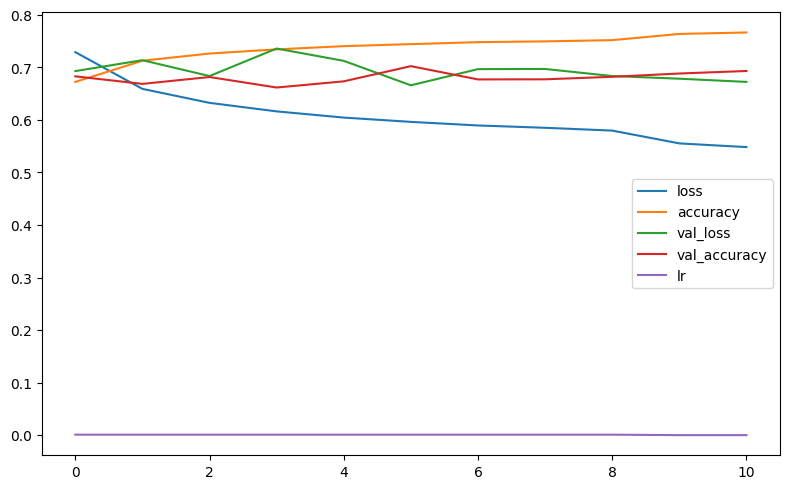

In [35]:
# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Show the figure
plt.tight_layout()
plt.show()

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
#y_true_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

3859/3859 [==============================] - 22s 6ms/step
Accuracy: 0.7004251528525732
Precision: 0.41253489550420275
Recall: 0.48748869110413756
F1 Score: 0.4136240316149637


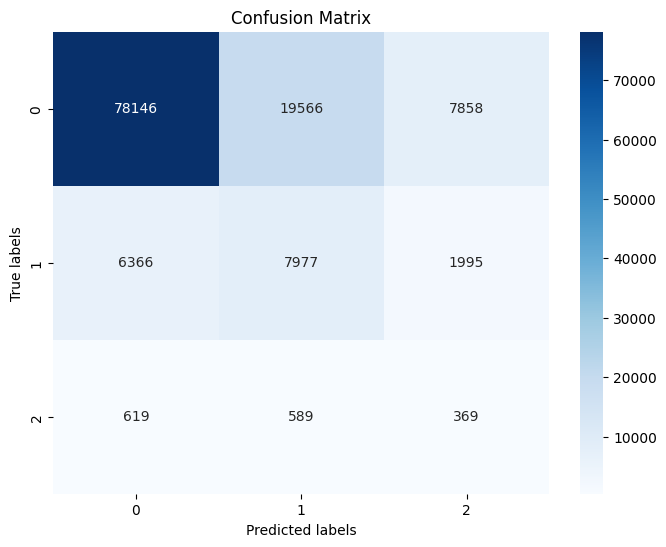

In [37]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test + 1, y_pred_classes + 1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# !pip install shap

In [20]:
# import shap

# shap.initjs()

# explainer = shap.KernelExplainer(model, X_train[:10, :])
# shap_values = explainer.shap_values(X_test, nsamples=50)

# shap.summary_plot(shap_values, X_test)
# # explainer = shap.KernelExplainer(model.predict,X_train)
# # shap_values = explainer.shap_values(X_test, nsamples=100)

# # shap.initjs()
# # shap.summary_plot(shap_values, X_test)